(10000, 2)

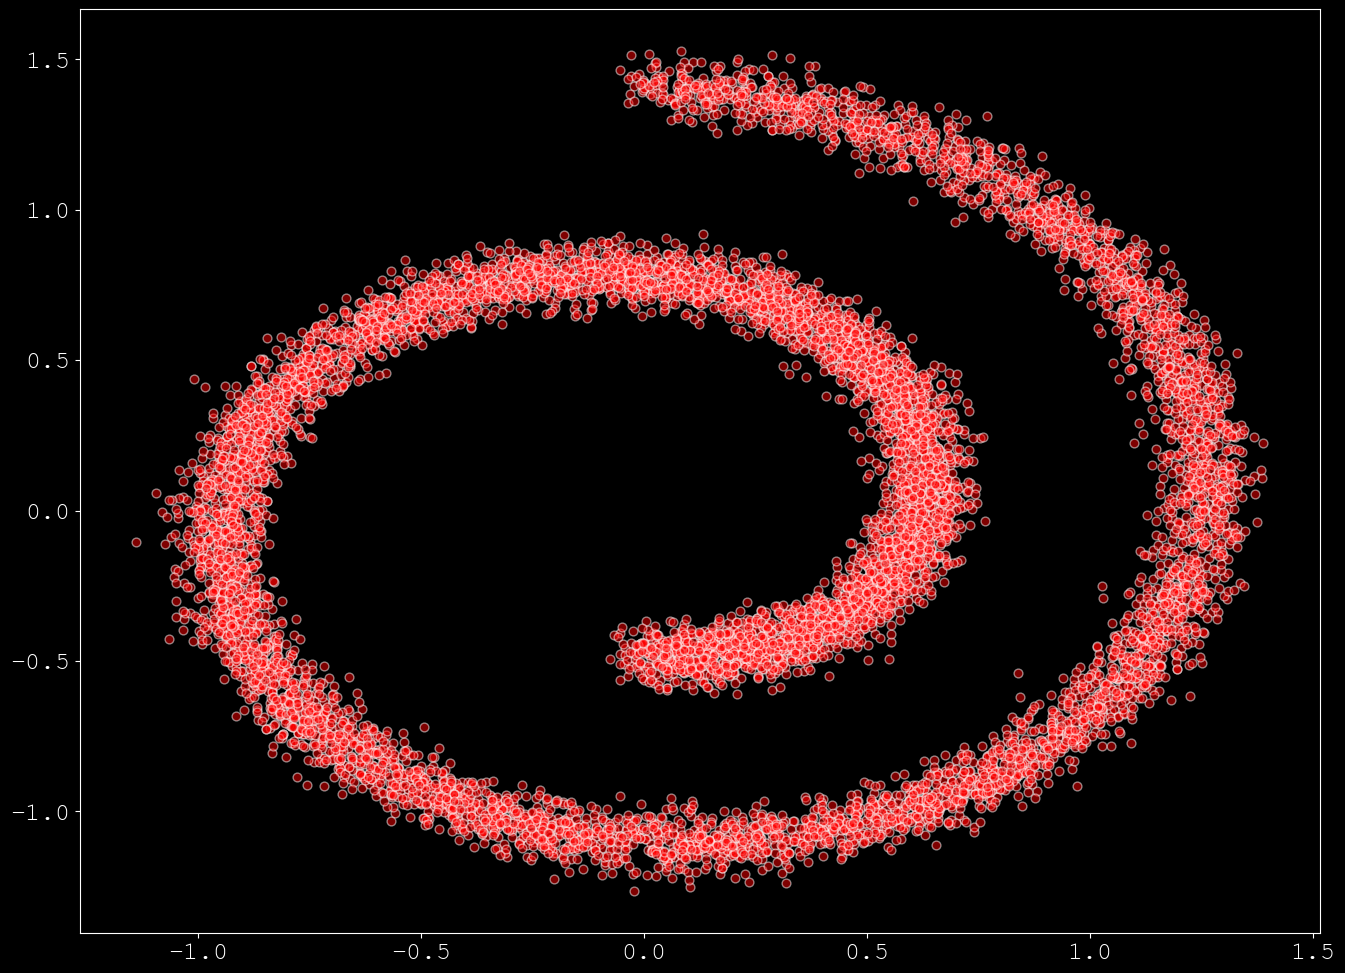

In [17]:
%matplotlib inline
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from sklearn.datasets import make_swiss_roll
from helper_plot import hdr_plot_style
from matplotlib import animation

hdr_plot_style()

Path("outputs").mkdir(exist_ok=True)

# Sample a batch from the swiss roll
def sample_batch(size, noise=0.5):
    x, _= make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0
# Plot it
data = sample_batch(10**4).T
plt.figure(figsize=(16, 12))
plt.scatter(*data, alpha=0.5, color='red', edgecolor='white', s=40)

data = data.T
data.shape

In [24]:
n_steps = 100
betas = jnp.array([0.015] * n_steps)
rng = jax.random.PRNGKey(0)
def forward_process(x_start, n_steps, key, noise = None):
    x_seq = [x_start]
    for n in range(n_steps):
        key, subkey = jax.random.split(key)
        x_seq.append((jnp.sqrt(1 - betas[n]) * x_seq[-1]) + betas[n] * jax.random.normal(subkey, x_start.shape))
    return x_seq
x_seq = forward_process(data, n_steps, rng)

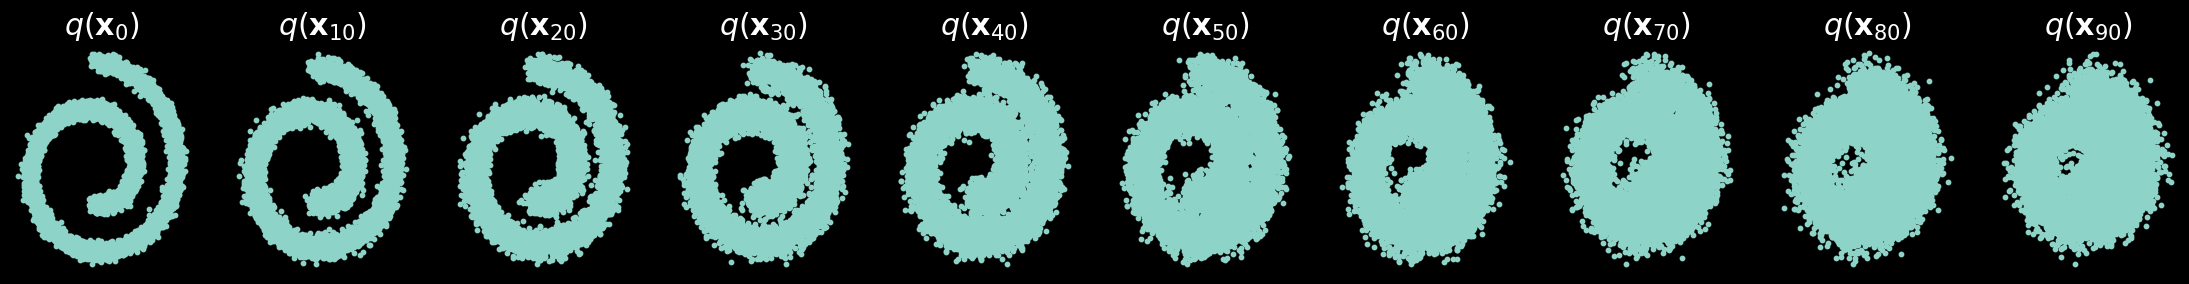

In [25]:
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(10):
    axs[i].scatter(x_seq[int((i / 10.0) * n_steps)][:, 0], x_seq[int((i / 10.0) * n_steps)][:, 1], s=10);
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(int((i / 10.0) * n_steps))+'})$')

In [26]:
def make_beta_schedule(schedule="linear", n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = jnp.linspace(start, end, n_timesteps)
    elif schedule == 'quad':
        betas = jnp.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == 'sigmoid':
        betas = jnp.linspace(-6, 6, n_timesteps)
        betas = jax.nn.sigmoid(betas) * (end - start) + start
    return betas

In [27]:
betas = make_beta_schedule(schedule="sigmoid", n_timesteps=n_steps)
alphas = 1 - betas
alphas_prod = jnp.cumprod(alphas)
alphas_prod_p = jnp.concatenate([jnp.array([1.0]), alphas_prod[:-1]])
alphas_bar_sqrt = jnp.sqrt(alphas_prod)
one_minus_alphas_bar_log = jnp.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = jnp.sqrt(1 - alphas_prod)

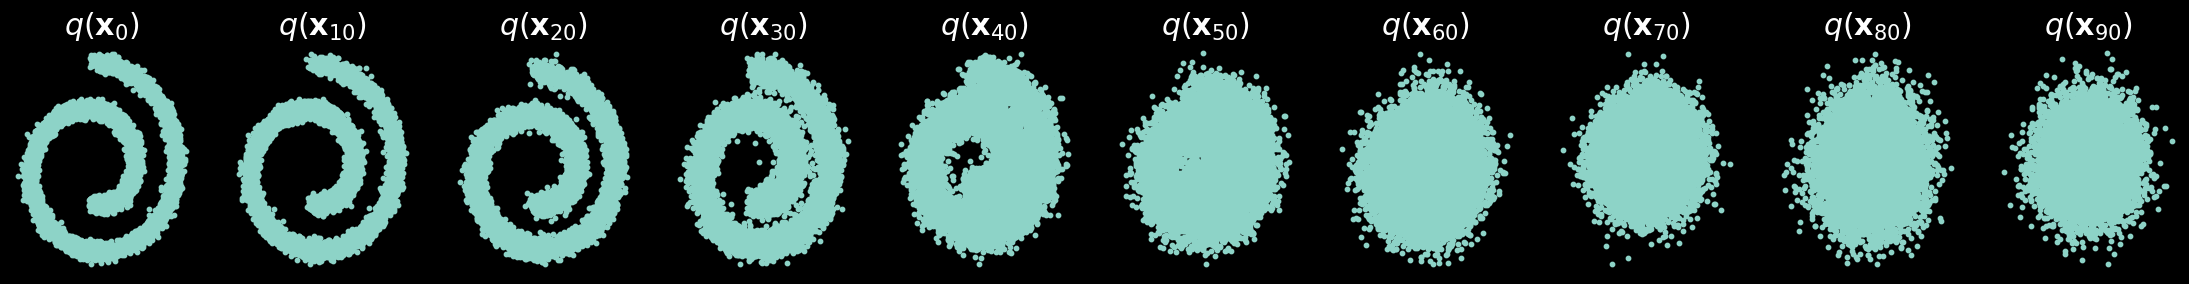

In [28]:
def extract(input, t, x):
    shape = x.shape
    output = jnp.take(input, t, axis=0)
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return jnp.reshape(output, reshape)

def q_sample(x_0, t, rng, noise = None):
    if noise is None:
        noise = jax.random.normal(rng, x_0.shape)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return alphas_t * x_0 + alphas_1_m_t * noise
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
rng = jax.random.PRNGKey(0)
for i in range(10):
    rng, subkey = jax.random.split(rng)
    q_i = q_sample(data, jnp.array([i * 10]), subkey)
    axs[i].scatter(q_i[:, 0], q_i[:, 1], s=10);
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')


In [29]:
posterior_mean_coef_1 = (betas * jnp.sqrt(alphas_prod_p) / (1 - alphas_prod))
posterior_mean_coef_2 = ((1 - alphas_prod_p) * jnp.sqrt(alphas) / (1 - alphas_prod))
posterior_variance = betas * (1 - alphas_prod_p) / (1 - alphas_prod)
posterior_log_variance_clipped = jnp.log(jnp.concatenate((posterior_variance[1][None], posterior_variance[1:]), 0))

In [30]:
@jax.jit
def q_posterior_mean_variance(x_0, x_t, t):
    coef_1 = extract(posterior_mean_coef_1, t, x_0)
    coef_2 = extract(posterior_mean_coef_2, t, x_0)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(posterior_log_variance_clipped, t, x_0)
    return mean, var

In [31]:
import flax.linen as nn

class ConditionalLinear(nn.Module):
    num_outputs: int
    num_classes: int
    @nn.compact
    def __call__(self, x, y):
        out = nn.Dense(self.num_outputs)(x)
        gamma = nn.Embed(self.num_classes, self.num_outputs)(y)
        return gamma * out

class ConditionalModel(nn.Module):
    num_classes: int
    @nn.compact
    def __call__(self, x, y):
        x = ConditionalLinear(128, self.num_classes)(x, y)
        x = nn.softplus(x)
        x = ConditionalLinear(128, self.num_classes)(x, y)
        x = nn.softplus(x)
        x = nn.Dense(4)(x)
        return x

In [32]:
from flax.training import train_state
import optax
def p_mean_variance(params, x, t):
    out = model.apply(params, x, t)
    mean, logvar = jnp.split(out, 2, axis=-1)
    # var = jnp.exp(logvar)
    return mean, logvar

In [33]:

def p_sample(params, x, t, rng):
    mean, logvar = p_mean_variance(params, x, t)
    noise = jax.random.normal(rng, mean.shape)
    shape = [x.shape[0]] + [1] * (len(mean.shape) - 1)
    # nonzero_mask = (1 - (t == 0))
    sample = mean + jnp.exp(logvar) * noise
    return sample

In [34]:
def p_sample_loop(params, shape, rng):
    rng, subkey = jax.random.split(rng)
    cur_x = jax.random.normal(subkey, shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        rng, subkey = jax.random.split(rng)
        cur_x = p_sample(params, cur_x, jnp.array([i]), subkey)
        x_seq.append(cur_x)
    return x_seq

In [35]:
def normal_kl(mean1, logvar1, mean2, logvar2):
    kl = 0.5 * (-1.0 + logvar2 - logvar1 + jnp.exp(logvar1 - logvar2) + ((mean1 - mean2) ** 2) * jnp.exp(-logvar2))
    return kl

def entropy(val):
    return (0.5 * (1 + jnp.log(2. * jnp.pi))) + 0.5 * jnp.log(val)

In [36]:
def compute_loss(true_mean, true_var, model_mean, model_var):
    # the KL divergence between model transition and posterior from data
    KL = normal_kl(true_mean, true_var, model_mean, model_var)
    # conditional entropies H_q(x^T|x^0) and H_q(x^1|x^0)
    H_start = entropy(betas[0])
    beta_full_trajectory = 1. - jnp.exp(jnp.sum(jnp.log(alphas)))
    H_end = entropy(beta_full_trajectory)
    H_prior = entropy(jnp.array([1.]))
    negL_bound = KL * n_steps + H_start - H_end + H_prior
    # the negL_bound if this was an isotropic Gaussian model of the data
    negL_gauss = entropy(jnp.array([1.]))
    negL_diff = negL_bound - negL_gauss
    L_diff_bits = negL_diff / jnp.log(2.)
    L_diff_bits_avg = L_diff_bits.mean()
    return L_diff_bits_avg

In [37]:
def loss_likelihood_bound(params, x_0, rng):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    rng, subkey = jax.random.split(rng)
    t = jax.random.randint(subkey, shape=(batch_size // 2 + 1,), minval=0, maxval=n_steps)
    t = jnp.concatenate([t, n_steps - t - 1], 0)[:batch_size]
    # Perform diffusion for step t
    rng, subkey = jax.random.split(rng)
    x_t = q_sample(x_0, t, subkey)
    # Compute the true mean and variance
    true_mean, true_var = q_posterior_mean_variance(x_0, x_t, t)
    # Infer the mean and variance with our model
    model_mean, model_var = p_mean_variance(params, x_t, t)
    # Compute the loss
    return compute_loss(true_mean, true_var, model_mean, model_var)

  0%|          | 0/5001 [00:00<?, ?it/s]

402.3432


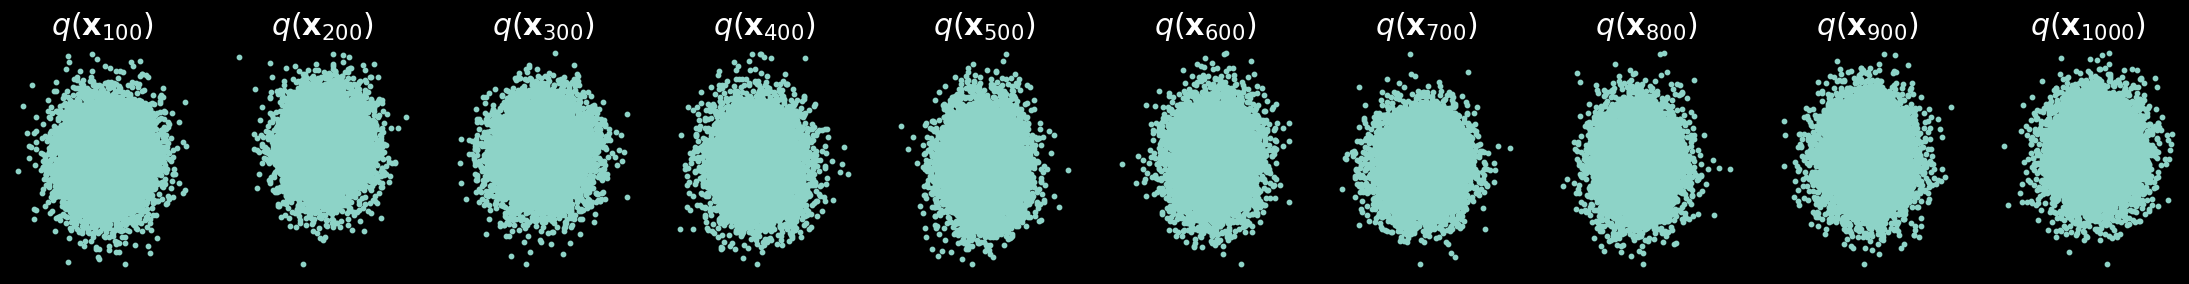

 20%|█▉        | 999/5001 [00:42<02:16, 29.32it/s] 

18.298124


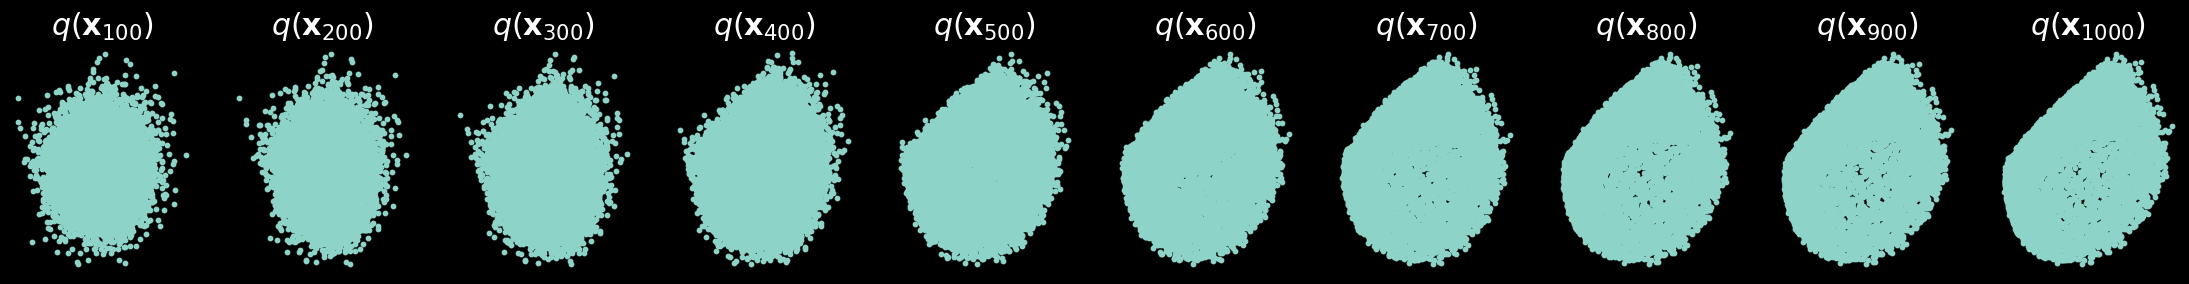

 40%|███▉      | 1997/5001 [01:21<01:39, 30.10it/s]

26.784336


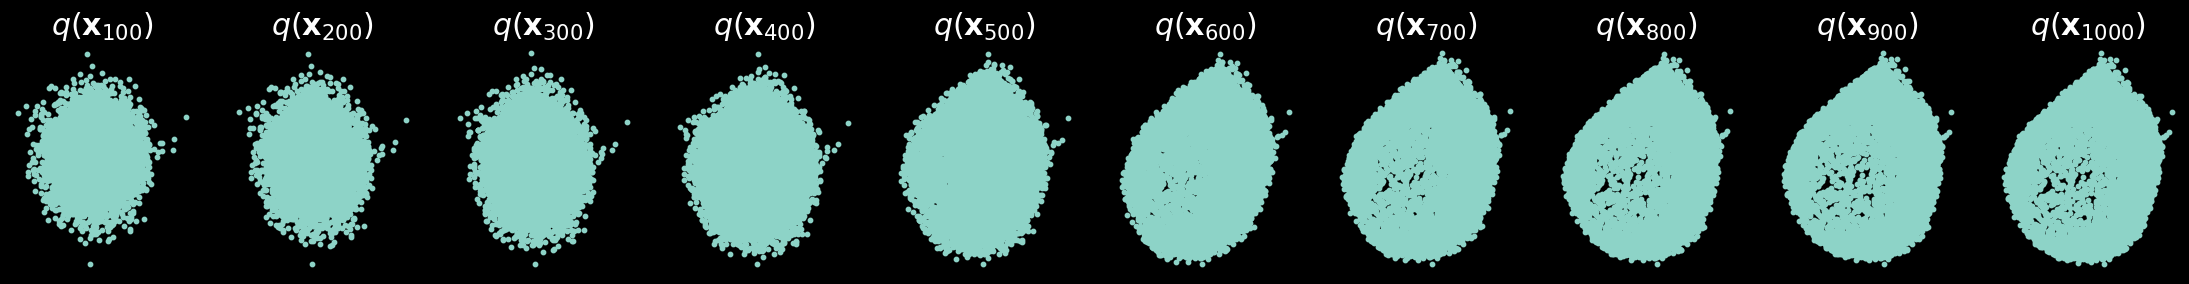

 60%|█████▉    | 2999/5001 [02:01<01:05, 30.55it/s]

6.2997885


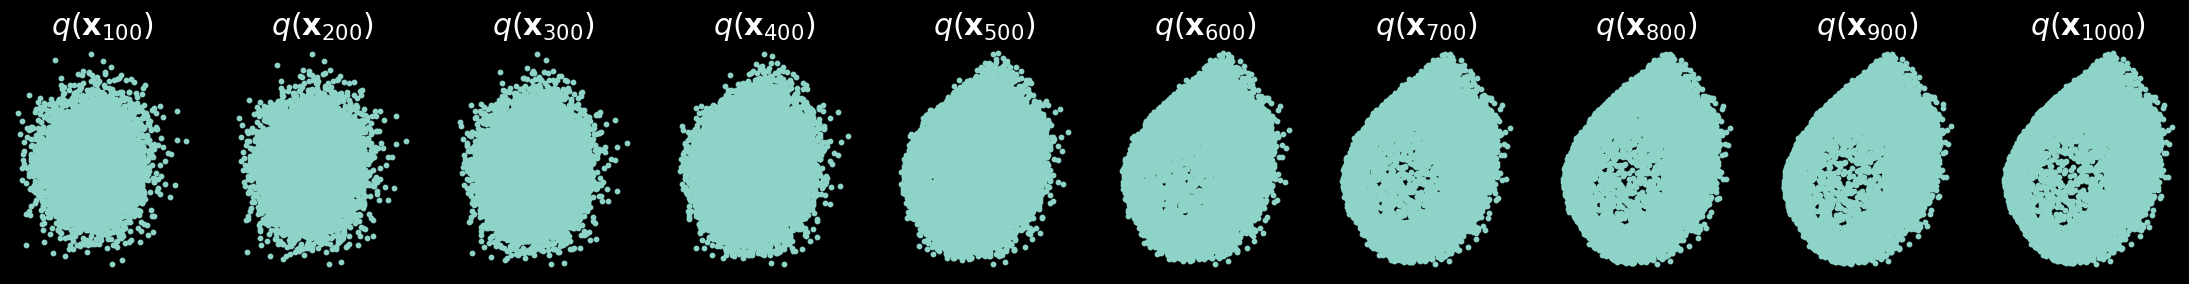

 80%|███████▉  | 4000/5001 [02:41<00:33, 29.54it/s]

7.3321686


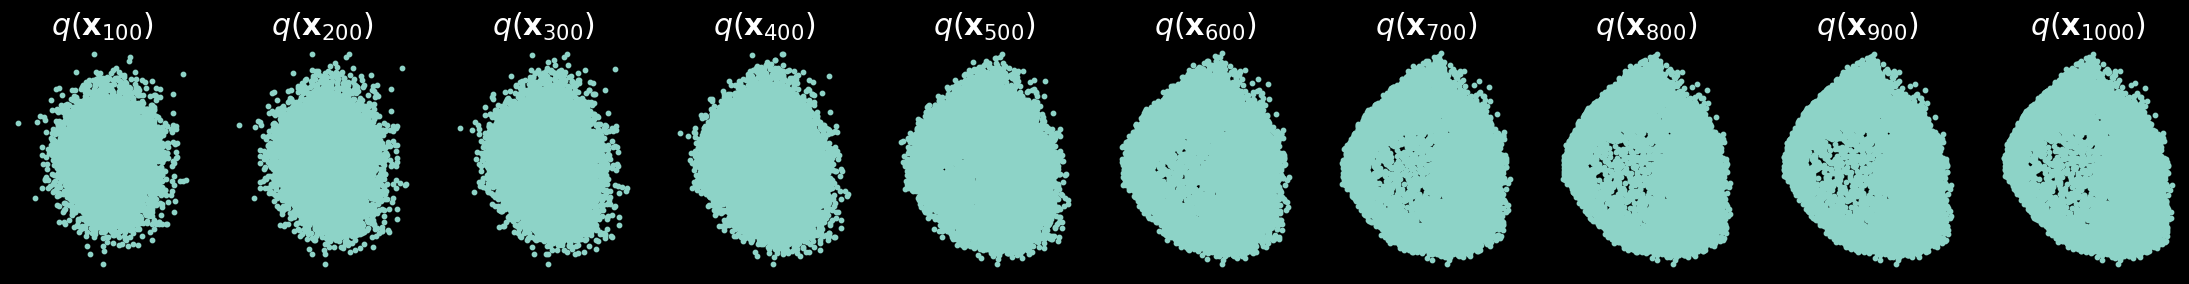

100%|█████████▉| 4998/5001 [03:20<00:00, 30.50it/s]

7.2319465


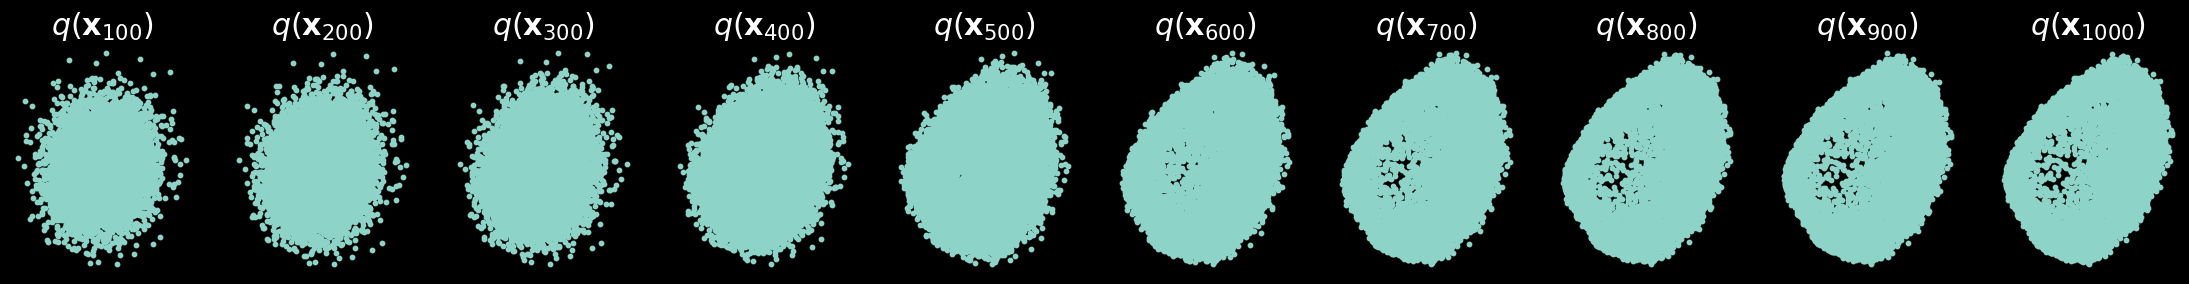

100%|██████████| 5001/5001 [03:27<00:00, 24.12it/s]


In [38]:
from tqdm import tqdm
batch_size = 128
steps = 5000
model = ConditionalModel(num_classes=n_steps)
rng, subkey = jax.random.split(rng)
params = model.init(subkey, jnp.ones((1, 2)), jnp.ones((1, 1), dtype=jnp.int32))
# optimizer = optax.adamw(1e-3)
optimizer = optax.chain(
    optax.clip_by_global_norm(1.),
    optax.adam(1e-3),
)
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

@jax.jit
def train_step(state, batch, rng):
  """Train for a single step."""
  rng, key = jax.random.split(rng)
  grads = jax.grad(loss_likelihood_bound, argnums=0)(state.params, batch,  key)
  state = state.apply_gradients(grads=grads)
  return state, rng
  
rng = jax.random.PRNGKey(0)
for t in tqdm(range(steps + 1)):
    # batch_idx = np.random.choice(data.shape[0], size=batch_size, replace=False)
    permutation = np.random.permutation(data.shape[0])
    for i in range(0, data.shape[0], batch_size):
      batch_idx = permutation[i:i+batch_size]
      batch = data[batch_idx]
      state, rng = train_step(state, batch, rng)
    if ((t % (steps // 5)) == 0):
        rng, key = jax.random.split(rng)
        print(loss_likelihood_bound(state.params, data, key))
        x_seq = p_sample_loop(state.params, data.shape, rng)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
          cur_x = x_seq[i * 10]
          axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10);
          axs[i-1].set_axis_off(); axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')
        plt.show()
        

In [58]:
class ConditionalModel(nn.Module):
    num_classes: int
    @nn.compact
    def __call__(self, x, y):
        x = ConditionalLinear(128, self.num_classes)(x, y)
        x = nn.softplus(x)
        x = ConditionalLinear(128, self.num_classes)(x, y)
        x = nn.softplus(x)
        x = ConditionalLinear(128, self.num_classes)(x, y)
        x = nn.softplus(x)
        x = nn.Dense(2)(x)
        return x

In [59]:
def p_sample(params, x, t, rng):
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x))
    eps_theta = model.apply(params, x, t)
    mean = (1 / jnp.sqrt(extract(alphas, t, x))) * (x - (eps_factor * eps_theta))
    z = jax.random.normal(rng, shape=x.shape)
    # Fixed sigma
    sigma_t = jnp.sqrt(extract(betas, t, x))
    sample = mean + sigma_t * z
    return sample

In [60]:
def approx_standard_normal_cdf(x):
    return 0.5 * (1.0 + jax.nn.tanh(jnp.sqrt(2. / jnp.pi) * (x + 0.044715 * jnp.power(x, 3))))

def discrete_gaussian_log_likelihood(x, means, log_scales):
    centered_x = x - means
    inv_stdv = jnp.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = approx_standard_normal_cdf(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = approx_standard_normal_cdf(min_in)
    log_cdf_plus = jnp.log(jnp.maximum(cdf_plus, 1e-12))
    log_one_minus_cdf_min = jnp.log(jnp.maximum(1. - cdf_min, 1e-12))
    cdf_delta = cdf_plus - cdf_min
    log_probs = jnp.where(x < -0.999, log_cdf_plus, jnp.where(x > 0.999, log_one_minus_cdf_min, jnp.log(jnp.maximum(cdf_delta, 1e-12))))
    return log_probs

In [61]:
def loss_variational(params, x_0, rng):
    batch_size = x_0.shape[0]
    t = jax.random.randint(rng, shape=(batch_size // 2 + 1,), minval=0, maxval=n_steps)
    t = jnp.concatenate([t, n_steps - t - 1])[:batch_size]
    x_t = q_sample(x_0, t, rng)
    true_mean, true_var = q_posterior_mean_variance(x_0, x_t, t)
    model_mean, model_var = p_mean_variance(params, x_t, t)
    kl = normal_kl(true_mean, true_var, model_mean, model_var)
    kl = jnp.mean(kl, 1) / jnp.log(2.)
    decoder_nll = -discrete_gaussian_log_likelihood(x_0, model_mean, 0.5 * model_var)
    decoder_nll = jnp.mean(decoder_nll, 1) / jnp.log(2.)
    output = jnp.where(t == 0, decoder_nll, kl)
    return jnp.mean(output)


In [62]:
def noise_estimation_loss(params, x_0, rng):
    batch_size = x_0.shape[0]
    rng, key = jax.random.split(rng)
    t = jax.random.randint(key, shape=(batch_size // 2 + 1,), minval=0, maxval=n_steps)
    t = jnp.concatenate([t, n_steps - t - 1])[:batch_size]
    a = extract(alphas_bar_sqrt, t, x_0)
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0)
    e = jax.random.normal(key, shape=x_0.shape)
    x_t = a * x_0 + am1 * e
    output = model.apply(params, x_t, t)
    return jnp.mean(jnp.square(output - e))

In [ ]:
from typing import Any
from dataclasses import dataclass
@dataclass
class ExponentialMovingAverage:
  """Exponential Moving Average as implemented in Tensorflow."""

  # Moving average of the parameters.
  param_ema: Any
  # Decay to use for the update (typical values are 0.999, 0.9999, etc...).
  decay: float
  # For how many steps we should just keep the new parameters instead of an
  # average (useful if we don't want the initial weights to be included in the
  # average).
  warmup_steps: int

  def update_moving_average(self, new_target: Any,
                            step: jnp.ndarray) -> Any:
    """Updates the moving average of the target.
    Args:
      new_target: New values of the target (example: weights of a network
        after gradient step).
      step: Current step (used only for warmup).
    Returns:
      The updated ExponentialMovingAverage.
    """
    factor = jnp.float32(step >= self.warmup_steps)
    delta = step - self.warmup_steps
    decay = jnp.minimum(self.decay, (1. + delta) / (10. + delta))
    decay *= factor
    weight_ema = jax.tree_util.tree_map(
        lambda a, b: (1 - decay) * a + decay * b, new_target, self.param_ema)
    return self.replace(param_ema=weight_ema)

  0%|          | 0/5001 [00:00<?, ?it/s]

0.9996324


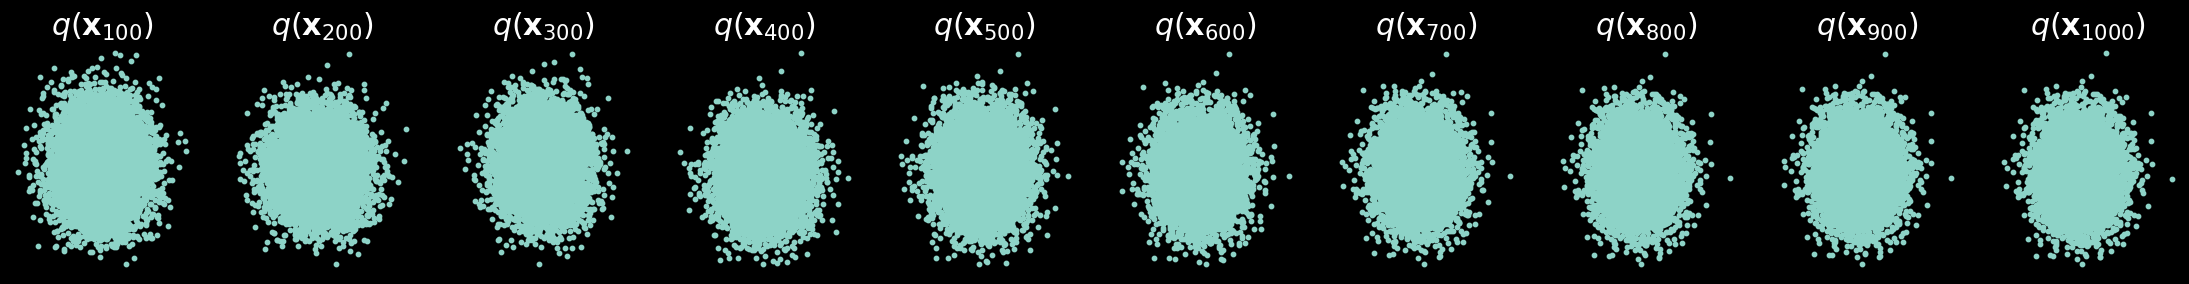

 20%|█▉        | 1000/5001 [00:52<02:45, 24.25it/s]

0.7193223


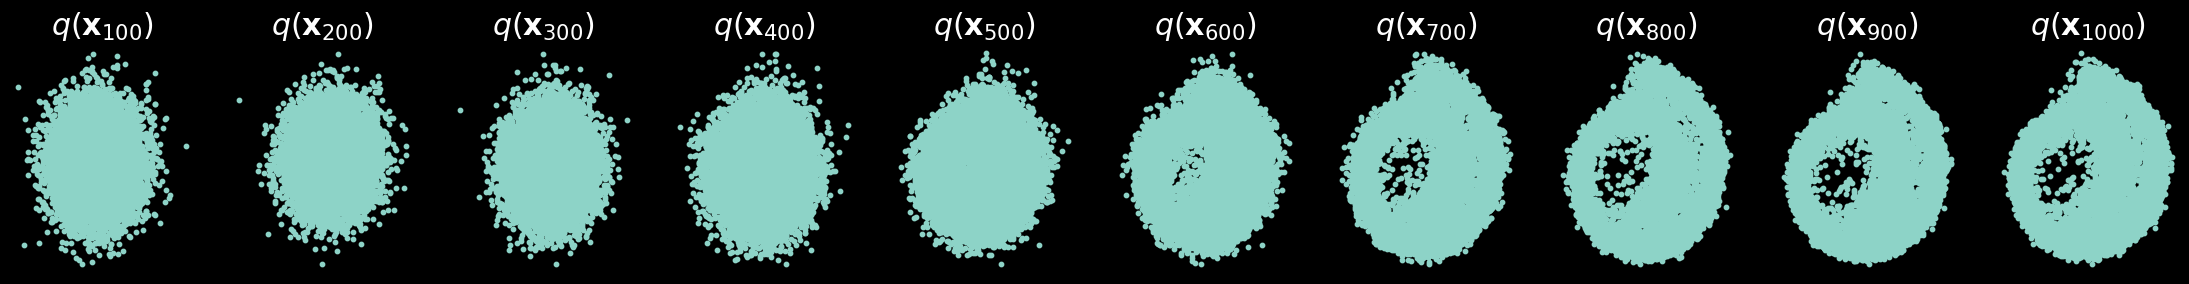

 40%|███▉      | 1999/5001 [01:41<02:02, 24.48it/s]

0.697829


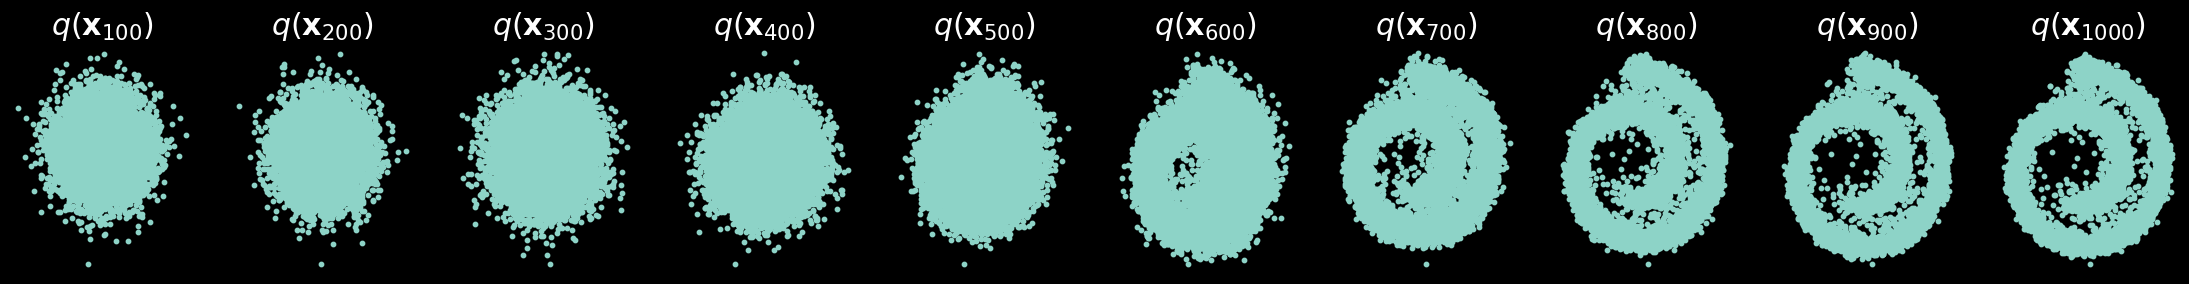

 60%|█████▉    | 3000/5001 [02:32<01:24, 23.78it/s]

0.69775546


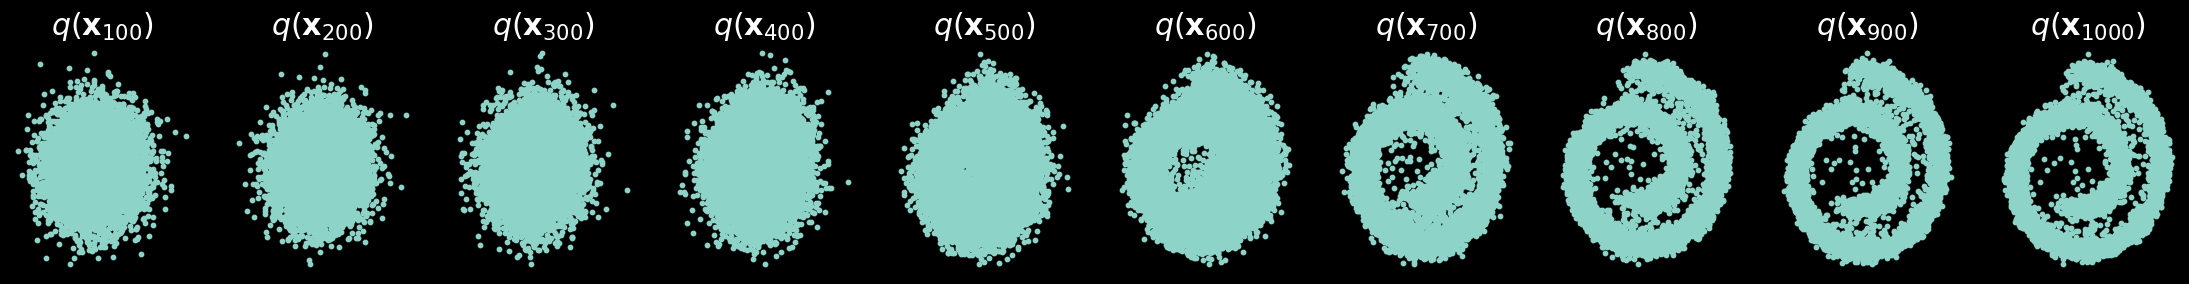

 80%|███████▉  | 4000/5001 [03:21<00:40, 24.85it/s]

0.6753837


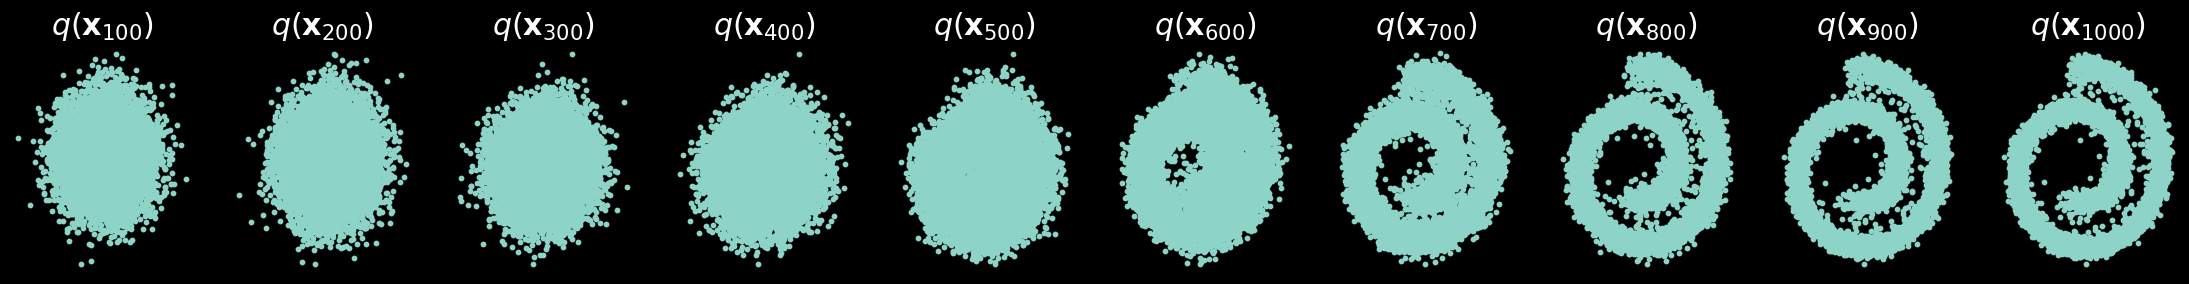

100%|█████████▉| 4998/5001 [04:10<00:00, 25.28it/s]

0.68027663


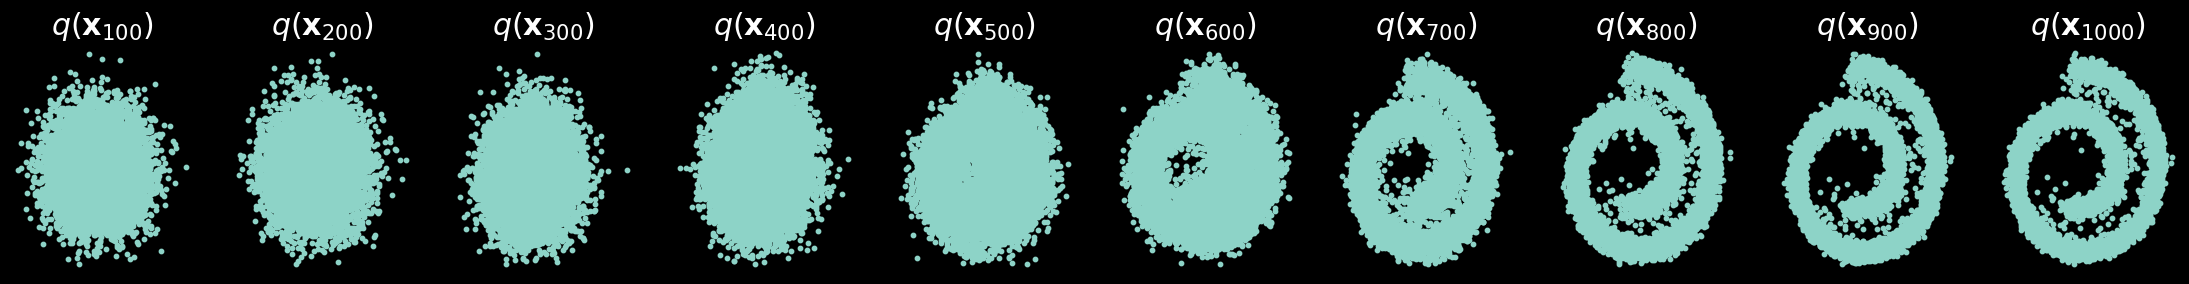

100%|██████████| 5001/5001 [04:19<00:00, 19.27it/s]


In [63]:
model = ConditionalModel(num_classes=n_steps)
params = model.init(jax.random.PRNGKey(0), jnp.ones((1, 2)), jnp.ones((1,), dtype=jnp.int32))
optimizer = optax.chain(
    optax.clip_by_global_norm(1.),
    optax.adam(1e-3),
)
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)
batch_size = 128


@jax.jit
def train_step(state, batch, rng):
  """Train for a single step."""
  rng, key = jax.random.split(rng)
  grads = jax.grad(noise_estimation_loss, argnums=0)(state.params, batch,  key)
  state = state.apply_gradients(grads=grads)
  return state, rng
  
rng = jax.random.PRNGKey(0)
for t in tqdm(range(steps + 1)):
    # batch_idx = np.random.choice(data.shape[0], size=batch_size, replace=False)
    permutation = np.random.permutation(data.shape[0])
    for i in range(0, data.shape[0], batch_size):
      batch_idx = permutation[i:i+batch_size]
      batch = data[batch_idx]
      state, rng = train_step(state, batch, rng)
    if ((t % (steps // 5)) == 0):
        rng, key = jax.random.split(rng)
        print(noise_estimation_loss(state.params, data, key))
        x_seq = p_sample_loop(state.params, data.shape, rng)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
          cur_x = x_seq[i * 10]
          axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10);
          axs[i-1].set_axis_off(); axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')
        plt.show()